<a href="https://colab.research.google.com/github/dyou-wbg/meta_processing/blob/main/0419_2KPair_TrueNegatives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Need 2K pair of titles to compare.
# From total of 8 sources.
# 64 possible combination for 2K pair
# Need to pick 32 pairs of titles across the sources
# or 157 titles per source to make 10K sample

In [1]:
10000/64

156.25

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from google.colab import drive
import csv
import os
import re
import pandas as pd
import numpy as np

#directory = '/content/drive/MyDrive/finalMetaFile'
#df_english_titles = pd.read_csv('/content/drive/MyDrive/finalMetaFile/50k_sample.csv')

#df_english_titles = pd.read_csv('/content/drive/MyDrive/10Ksample.csv')
#df_english_titles.columns

directory = '/content/drive/MyDrive/finalMetaFile'
df = pd.read_csv(os.path.join(directory, 'combined_metadata_final12_features.csv'))
df=df[['sourcename', 'title']]


df['sourcename'] = df['sourcename'].apply(lambda x: x.replace('metadata_', ''))
df['sourcename'] = df['sourcename'].apply(lambda x: x.replace('_unifiedColName.csv', ''))
df['sourcename'].replace(['url1_ie_table_complete', 'scopus_fixed_encoding','SSRN'], ['3ie', 'scopus','ssrn'], inplace=True)


Mounted at /content/drive


<ipython-input-1-54ccb68a7028>:18: DtypeWarning: Columns (1,2,3,4,5,7,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(directory, 'combined_metadata_final12_features.csv'))


In [8]:
df.head()

,sourcename,title
0,jstor,Economic Education in Our Schools: A Renewed M...
1,jstor,Can Germany Contain Russia Safely?
2,jstor,Assessing the Impact of Sarbanes-Oxley Act on ...
3,jstor,Childhood Educational Disruption and Later Lif...
4,jstor,The Exclusion of Liability for Negligence


In [10]:
df.groupby('sourcename').size().to_frame(name='count')

,count
sourcename,
3ie,11377
econlit,19121
elsevier,242410
jstor,1095398
repec,915771
scopus,961490
semantic_scholar,7912377
ssrn,99106


# check proportion

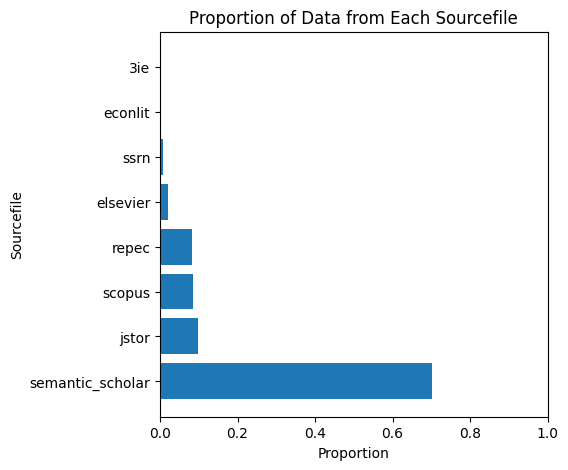

In [11]:


import matplotlib.pyplot as plt
source_df = df['sourcename'].value_counts()
total_df = len(df)
source_proportions = source_df / total_df

plt.figure(figsize=(5, 5))
plt.barh(source_proportions.index, source_proportions.values)
plt.ylabel('Sourcefile')
plt.xlabel('Proportion')
plt.xlim(0,1)
plt.title('Proportion of Data from Each Sourcefile')
plt.show()


# lowering and drop edge-cases

In [2]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize

df['title'] = df['title'].str.lower()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
def remove_non_english(df):
  def is_english(text):
    words = word_tokenize(text)
    english_word_count = sum(len(word) >= 2 for word in words)
    return english_word_count / len(words) >= 0.9

  df_filtered = df[df['title'].apply(is_english)]
  return df_filtered

df['title'] = df['title'].astype(str)
df = df[~df['title'].str.contains('و|д|я|š|ü|à|é|ś|ä|ú|의|θ|λ|ό|τ|η|τ|α|の|と', regex=True)]
df = remove_non_english(df.copy())


In [4]:

df = df.drop(df[df['title'].isin(['sustaining fiscal policy through immigration1'
,'sustaining fiscal policy through immigration'
,'voluntary environmental agreements in developing countries: the colombian experience'
,'work and employment'
,'the role of social grants on commercialization among smallholder farmers in south africa: evidence from a continuous treatment approach'
,'voluntary environmental agreements in developing countries: the colombian experience'
,'the role of social grants on commercialization among smallholder farmers in south africa: evidence from a continuous treatment approach'
,'sustaining fiscal policy through immigration'
,'sustaining fiscal policy through immigration1'
,'work and employment'])].index)


# title anatomy

In [5]:
def count_words(title):
  words = title.split()
  return len(words)

df['word_count'] = df['title'].apply(count_words)
df.to_csv(os.path.join(directory, 'combined_metadata_final12_features_MakePair.csv'), index=False)

In [ ]:
# this takes too long. It is linear with word_count in most case in anyway. Drop this.
from string import printable
from collections import Counter

printable_dict = {c:i for i,c in enumerate(printable)}

def vectorize(title):
    cnt = Counter(title)
    array = [0 for _ in printable]+[0]
    for c,n in cnt.items():
        if c in printable_dict:
            array[printable_dict[c]]=n
        else:
            array[-1]+=n
    return np.array(array)

vects = []
for title in df.title:
    vects.append(vectorize(title))

df['vects'] = vects

def sum_array(array):
  sum = 0
  for element in array:
    sum += element
  return sum

df['sum_array'] = df['vects'].apply(sum_array)
df = df.sort_values(by=[ 'word_count','sum_array'], ascending=True)
df.drop(['vects'], axis=1, inplace=True)

# frequency

In [6]:
df.groupby('sourcename')['word_count'].agg(lambda x: x.value_counts().index[0])

sourcename
3ie                 12
econlit             10
elsevier            10
jstor                9
repec               10
scopus              10
semantic_scholar    10
ssrn                 9
Name: word_count, dtype: int64

In [ ]:

# Filter the DataFrame by sourcename.
df_3ie = df[df['sourcename'] == '3ie']
df_econlit = df[df['sourcename'] == 'econlit']
df_ssrn = df[df['sourcename'] == 'ssrn']
df_elsevier = df[df['sourcename'] == 'elsevier']
df_repec = df[df['sourcename'] == 'repec']
df_scopus = df[df['sourcename'] == 'scopus']
df_jstor = df[df['sourcename'] == 'jstor']
df_semantic_scholar = df[df['sourcename'] == 'semantic_scholar']

df_repec = df_repec[df_repec['word_count'] < 1000]


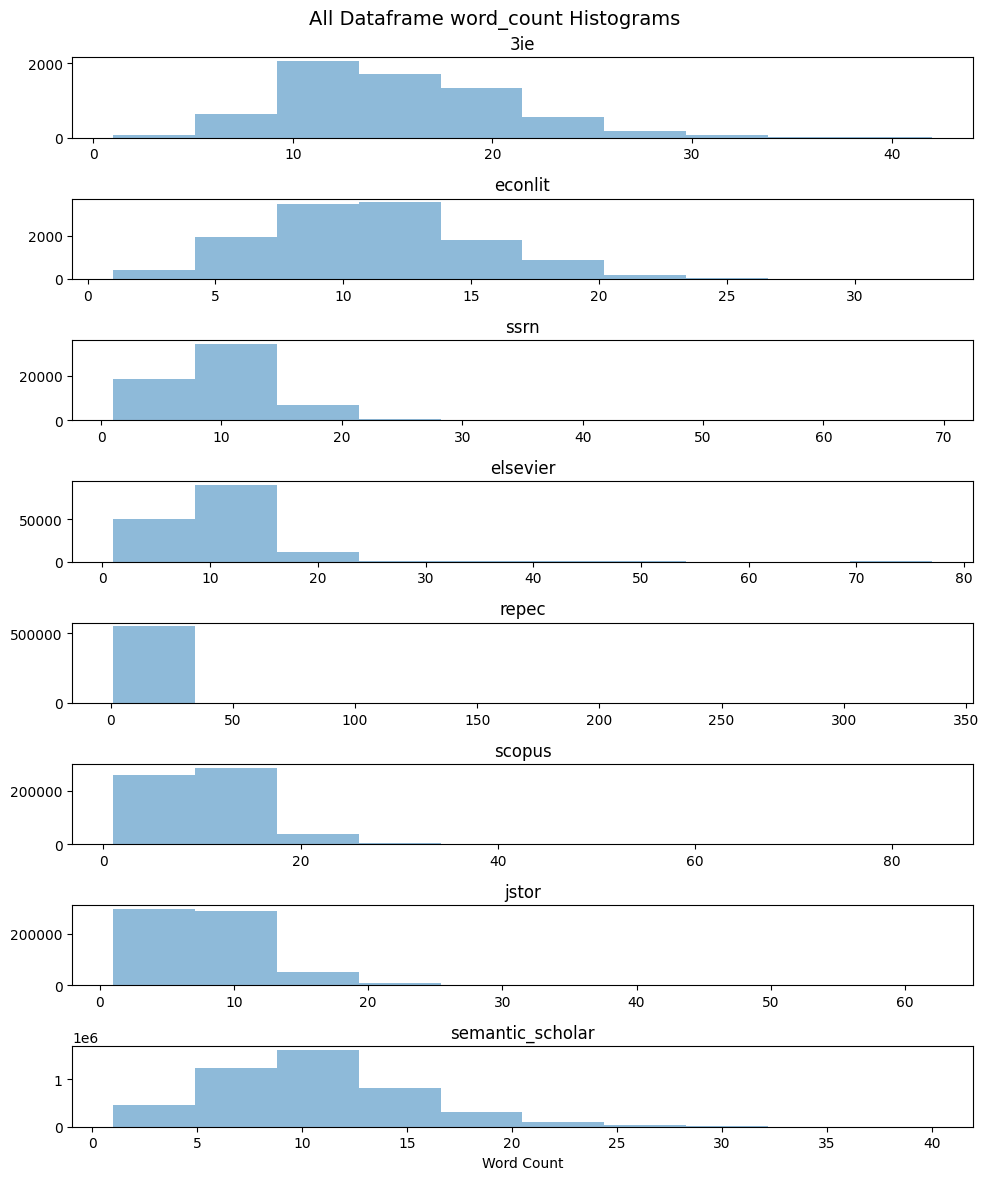

In [20]:
fig, ax = plt.subplots(8, 1, figsize=(10, 12))

fig.suptitle('All Dataframe word_count Histograms', fontsize=14)
df_repec = df_repec[df_repec['word_count'] < 1000]
ax[0].hist(df_3ie['word_count'], label='3ie', alpha=0.5)
ax[0].set_title('3ie')
ax[1].hist(df_econlit['word_count'], label='econlit', alpha=0.5)
ax[1].set_title('econlit')
ax[2].hist(df_ssrn['word_count'], label='ssrn', alpha=0.5)
ax[2].set_title('ssrn')
ax[3].hist(df_elsevier['word_count'], label='elsevier', alpha=0.5)
ax[3].set_title('elsevier')
ax[4].hist(df_repec['word_count'], label='repec', alpha=0.5)
ax[4].set_title('repec')
ax[5].hist(df_scopus['word_count'], label='scopus', alpha=0.5)
ax[5].set_title('scopus')
ax[6].hist(df_jstor['word_count'], label='jstor', alpha=0.5)
ax[6].set_title('jstor')
ax[7].hist(df_semantic_scholar['word_count'], label='semantic_scholar', alpha=0.5)
ax[7].set_title('semantic_scholar')
ax[7].set_xlabel('Word Count')


plt.tight_layout()
plt.show()


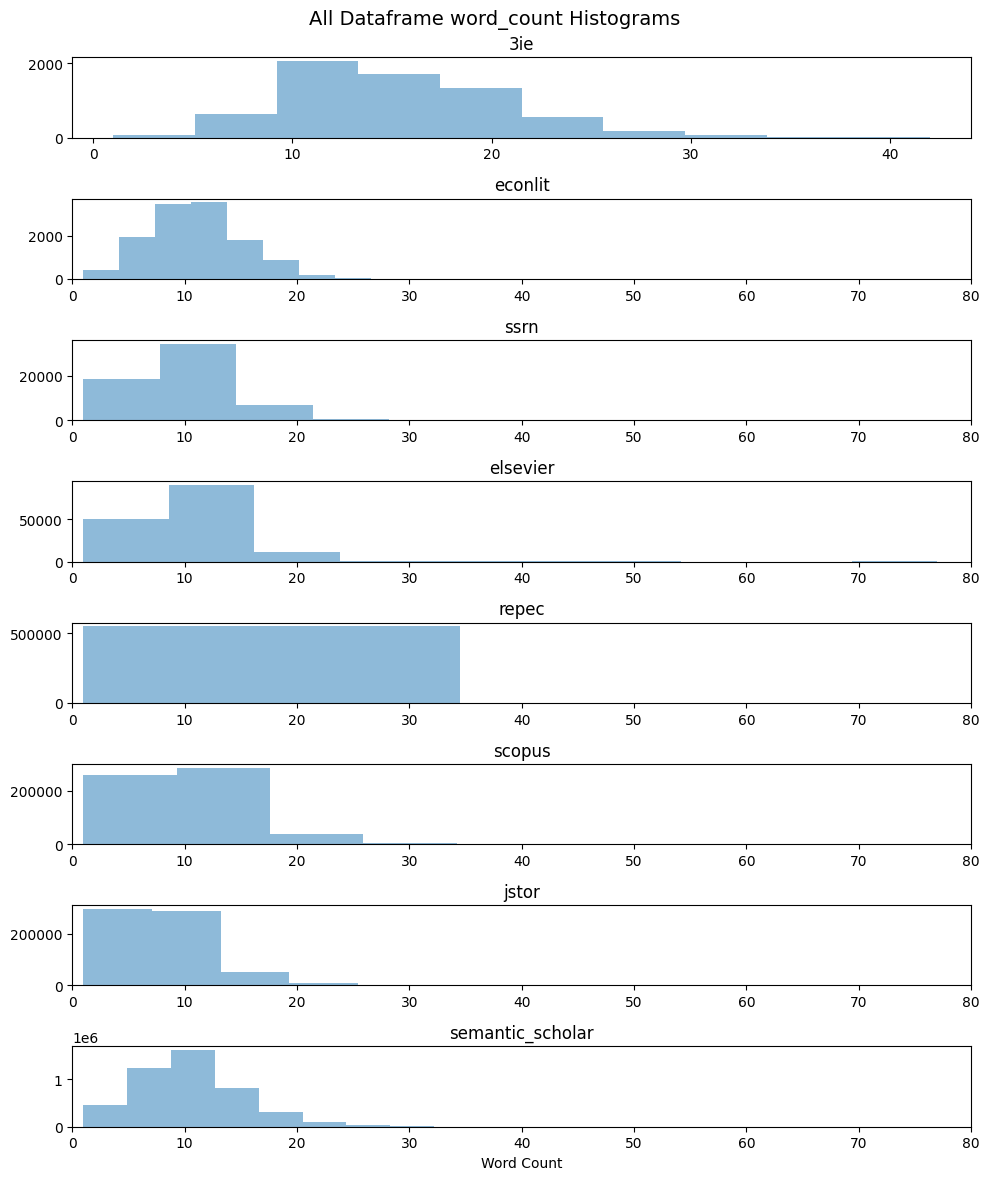

In [21]:

fig, ax = plt.subplots(8, 1, figsize=(10, 12))

fig.suptitle('All Dataframe word_count Histograms', fontsize=14)

ax[0].hist(df_3ie['word_count'], label='3ie', alpha=0.5)
ax[0].set_title('3ie')
ax[1].hist(df_econlit['word_count'], label='econlit', alpha=0.5)
ax[1].set_title('econlit')
ax[1].set_xlim(0, 80)
ax[2].hist(df_ssrn['word_count'], label='ssrn', alpha=0.5)
ax[2].set_title('ssrn')
ax[2].set_xlim(0, 80)
ax[3].hist(df_elsevier['word_count'], label='elsevier', alpha=0.5)
ax[3].set_title('elsevier')
ax[3].set_xlim(0, 80)
ax[4].hist(df_repec['word_count'], label='repec', alpha=0.5)
ax[4].set_title('repec')
ax[4].set_xlim(0, 80)
ax[5].hist(df_scopus['word_count'], label='scopus', alpha=0.5)
ax[5].set_title('scopus')
ax[5].set_xlim(0, 80)
ax[6].hist(df_jstor['word_count'], label='jstor', alpha=0.5)
ax[6].set_title('jstor')
ax[6].set_xlim(0, 80)
ax[7].hist(df_semantic_scholar['word_count'], label='semantic_scholar', alpha=0.5)
ax[7].set_title('semantic_scholar')
ax[7].set_xlabel('Word Count')
ax[7].set_xlim(0, 80)


plt.tight_layout()
plt.show()


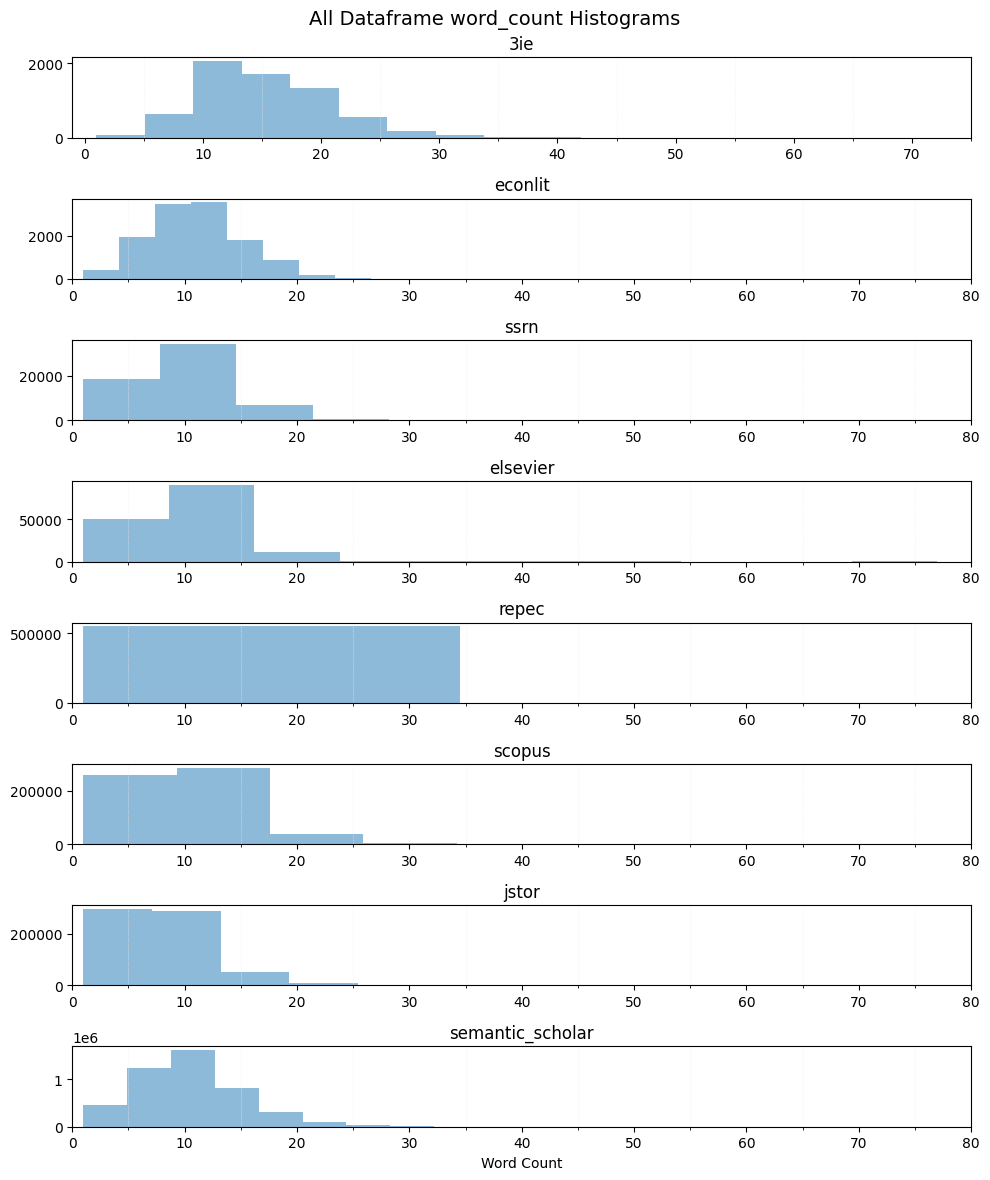

In [22]:

fig, ax = plt.subplots(8, 1, figsize=(10, 12))

fig.suptitle('All Dataframe word_count Histograms', fontsize=14)

ax[0].hist(df_3ie['word_count'], label='3ie', alpha=0.5)
ax[0].set_title('3ie')
ax[1].hist(df_econlit['word_count'], label='econlit', alpha=0.5)
ax[1].set_title('econlit')
ax[1].set_xlim(0, 80)
ax[2].hist(df_ssrn['word_count'], label='ssrn', alpha=0.5)
ax[2].set_title('ssrn')
ax[2].set_xlim(0, 80)
ax[3].hist(df_elsevier['word_count'], label='elsevier', alpha=0.5)
ax[3].set_title('elsevier')
ax[3].set_xlim(0, 80)
ax[4].hist(df_repec['word_count'], label='repec', alpha=0.5)
ax[4].set_title('repec')
ax[4].set_xlim(0, 80)
ax[5].hist(df_scopus['word_count'], label='scopus', alpha=0.5)
ax[5].set_title('scopus')
ax[5].set_xlim(0, 80)
ax[6].hist(df_jstor['word_count'], label='jstor', alpha=0.5)
ax[6].set_title('jstor')
ax[6].set_xlim(0, 80)
ax[7].hist(df_semantic_scholar['word_count'], label='semantic_scholar', alpha=0.5)
ax[7].set_title('semantic_scholar')
ax[7].set_xlabel('Word Count')
ax[7].set_xlim(0, 80)

# Make minor ticks every 5
ax[0].set_xticks(np.arange(0, 80, 5), minor=True)
ax[1].set_xticks(np.arange(0, 80, 5), minor=True)
ax[2].set_xticks(np.arange(0, 80, 5), minor=True)
ax[3].set_xticks(np.arange(0, 80, 5), minor=True)
ax[4].set_xticks(np.arange(0, 80, 5), minor=True)
ax[5].set_xticks(np.arange(0, 80, 5), minor=True)
ax[6].set_xticks(np.arange(0, 80, 5), minor=True)
ax[7].set_xticks(np.arange(0, 80, 5), minor=True)

# Make gridlines minor
ax[0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax[1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax[2].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax[3].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax[4].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax[5].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax[6].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax[7].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()


Every source show frequency of highest dist. of title when word_count is between 10-12.

In [23]:
10000/8

1250.0

In [93]:
# prompt: Randomly select 1250 titles from each sourcename when word_count is between 10 and 12.

import pandas as pd
df_3ie_10_12 = df_3ie[(df_3ie['word_count'] >= 10) & (df_3ie['word_count'] <= 12)]
df_econlit_10_12 = df_econlit[(df_econlit['word_count'] >= 10) & (df_econlit['word_count'] <= 12)]
df_ssrn_10_12 = df_ssrn[(df_ssrn['word_count'] >= 10) & (df_ssrn['word_count'] <= 12)]
df_elsevier_10_12 = df_elsevier[(df_elsevier['word_count'] >= 10) & (df_elsevier['word_count'] <= 12)]
df_repec_10_12 = df_repec[(df_repec['word_count'] >= 10) & (df_repec['word_count'] <= 12)]
df_scopus_10_12 = df_scopus[(df_scopus['word_count'] >= 10) & (df_scopus['word_count'] <= 12)]
df_jstor_10_12 = df_jstor[(df_jstor['word_count'] >= 10) & (df_jstor['word_count'] <= 12)]
df_semantic_scholar_10_12 = df_semantic_scholar[(df_semantic_scholar['word_count'] >= 10) & (df_semantic_scholar['word_count'] <= 12)]

df_3ie_10_12 = df_3ie_10_12.sample(n=1250)
df_econlit_10_12 = df_econlit_10_12.sample(n=1250)
df_ssrn_10_12 = df_ssrn_10_12.sample(n=1250)
df_elsevier_10_12 = df_elsevier_10_12.sample(n=1250)
df_repec_10_12 = df_repec_10_12.sample(n=1250)
df_scopus_10_12 = df_scopus_10_12.sample(n=1250)
df_jstor_10_12 = df_jstor_10_12.sample(n=1250)
df_semantic_scholar_10_12 = df_semantic_scholar_10_12.sample(n=1250)

df_make_pair = pd.concat([df_3ie_10_12, df_econlit_10_12, df_ssrn_10_12, df_elsevier_10_12, df_repec_10_12, df_scopus_10_12, df_jstor_10_12, df_semantic_scholar_10_12])

df_make_pair.to_csv(os.path.join(directory, 'combined_metadata_final12_features_MakePair_10k.csv'), index=False)


In [94]:
len(df_make_pair)

10000

In [95]:
# prompt: Select 2000 / 8 = 250 titles from each source

import pandas as pd
# Select 250 titles from each source
df_3ie_10_12 = df_3ie_10_12.sample(n=250)
df_econlit_10_12 = df_econlit_10_12.sample(n=250)
df_ssrn_10_12 = df_ssrn_10_12.sample(n=250)
df_elsevier_10_12 = df_elsevier_10_12.sample(n=250)
df_repec_10_12 = df_repec_10_12.sample(n=250)
df_scopus_10_12 = df_scopus_10_12.sample(n=250)
df_jstor_10_12 = df_jstor_10_12.sample(n=250)
df_semantic_scholar_10_12 = df_semantic_scholar_10_12.sample(n=250)

# Concatenate the selected titles into a new DataFrame
df_make_pair_2 = pd.concat([df_3ie_10_12, df_econlit_10_12, df_ssrn_10_12, df_elsevier_10_12, df_repec_10_12, df_scopus_10_12, df_jstor_10_12, df_semantic_scholar_10_12])

# Save the DataFrame to a CSV file
df_make_pair_2.to_csv(os.path.join(directory, 'combined_metadata_final12_features_MakePair_2k.csv'), index=False)


In [96]:
len(df_make_pair_2)

2000

In [97]:
df_make_pair_2.to_csv(os.path.join(directory, 'combined_metadata_final12_features_MakePair_2k.csv'), index=False)


In [98]:
df_make_pair_2.head()

,sourcename,title,word_count
10219173,3ie,the clean development mechanism and technology...,11
10214056,3ie,randomized controlled ethanol cookstove interv...,12
10213858,3ie,daylight saving time and energy consumption: t...,10
10216319,3ie,malaria eradication and educational attainment...,11
10219054,3ie,minimum wage law for domestic workers: impact ...,12


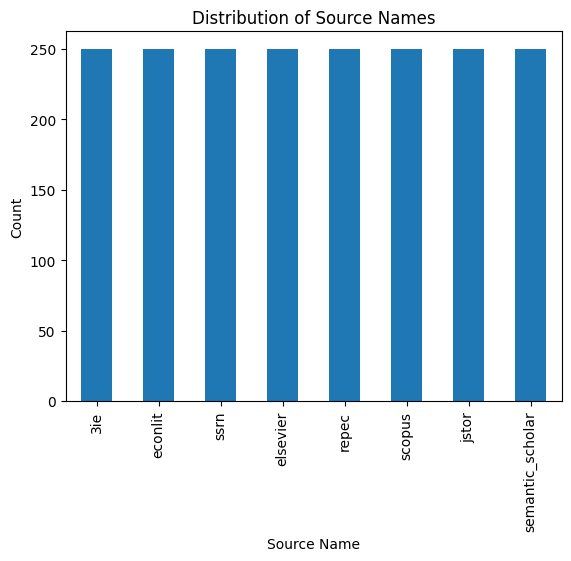

In [99]:

df_make_pair_2['sourcename'].value_counts().plot(kind='bar')
plt.xlabel('Source Name')
plt.ylabel('Count')
plt.title('Distribution of Source Names')
plt.show()


In [100]:
len(df_make_pair_2)

2000

In [101]:
from string import printable
from collections import Counter

printable_dict = {c:i for i,c in enumerate(printable)}

def vectorize(title):
    cnt = Counter(title)
    array = [0 for _ in printable]+[0]
    for c,n in cnt.items():
        if c in printable_dict:
            array[printable_dict[c]]=n
        else:
            array[-1]+=n
    return np.array(array)

vects = []
for title in df_make_pair_2.title:
    vects.append(vectorize(title))

In [38]:
import math
math.sqrt(2000)

44.721359549995796

In [39]:
44.721359549995796/8

5.5901699437494745

In [92]:
len(df_3ie_10_12)

6

In [103]:
len(df_3ie_10_12)

250

In [104]:
df_3ie_10_12 = df_3ie_10_12.sample(n=6)
df_econlit_10_12 = df_econlit_10_12.sample(n=6)
df_ssrn_10_12 = df_ssrn_10_12.sample(n=6)
df_elsevier_10_12 = df_elsevier_10_12.sample(n=6)
df_repec_10_12 = df_repec_10_12.sample(n=6)
df_scopus_10_12 = df_scopus_10_12.sample(n=6)
df_jstor_10_12 = df_jstor_10_12.sample(n=6)
df_semantic_scholar_10_12 = df_semantic_scholar_10_12.sample(n=6)

# Concatenate the selected titles into a new DataFrame
df_make_pair_2k_pair = pd.concat([df_3ie_10_12, df_econlit_10_12, df_ssrn_10_12, df_elsevier_10_12, df_repec_10_12, df_scopus_10_12, df_jstor_10_12, df_semantic_scholar_10_12])

# Save the DataFrame to a CSV file
df_make_pair_2k_pair.to_csv(os.path.join(directory, 'combined_metadata_final12_features_MakePair_2kpair_final.csv'), index=False)

In [105]:
df_make_pair_2k_pair.head(30)

,sourcename,title,word_count
10213891,3ie,do environmental messages work on the poor? ex...,12
10220848,3ie,testing the effectiveness of transfer interven...,10
10215991,3ie,a randomized trial of multivitamin supplementa...,12
10222334,3ie,three essays on climate change adaptation in r...,10
10212899,3ie,effect of scientific argumentation on the deve...,10
10219232,3ie,environmental non-governmental organizations a...,10
10225082,econlit,the times they are a-changing: experimenting w...,10
10230182,econlit,what makes voters turn out: the effects of pol...,11
10223669,econlit,a proposed methodology for literature review o...,12
10225994,econlit,socioeconomic status and inequalities in child...,10


In [106]:
len(df_make_pair_2k_pair)

48

In [107]:
from string import printable
from collections import Counter

printable_dict = {c:i for i,c in enumerate(printable)}

def vectorize(title):
    cnt = Counter(title)
    array = [0 for _ in printable]+[0]
    for c,n in cnt.items():
        if c in printable_dict:
            array[printable_dict[c]]=n
        else:
            array[-1]+=n
    return np.array(array)

vects = []
for title in df_make_pair_2k_pair.title:
    vects.append(vectorize(title))

# cosine sim

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_make_pair_2k_pair['title'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [109]:
%%time
import csv

num_titles = len(df_make_pair_2k_pair)

with open('/content/drive/MyDrive/finalMetaFile/similarity_score_2Kpair_over10Percent.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["Title 1", "Title 2", "Similarity Score"])

  for i in range(num_titles):
    current_title = df_make_pair_2k_pair.iloc[i]['title']
    similarities = cosine_sim[i]

    for j in range(num_titles):
      if i != j:
        other_title = df_make_pair_2k_pair.iloc[j]['title']
        similarity_score = similarities[j]

        if similarity_score > 0.0001:
          writer.writerow([current_title, other_title, similarity_score])
          print(i + 1,f"{current_title} & {other_title} (score: {similarity_score:.4f})")

1 do environmental messages work on the poor? experimental evidence from brazilian favelas & testing the effectiveness of transfer interventions using solomon four-group designs (score: 0.0182)
1 do environmental messages work on the poor? experimental evidence from brazilian favelas & three essays on climate change adaptation in rural african communities (score: 0.0552)
1 do environmental messages work on the poor? experimental evidence from brazilian favelas & effect of scientific argumentation on the development of critical thinking (score: 0.0816)
1 do environmental messages work on the poor? experimental evidence from brazilian favelas & environmental non-governmental organizations and urban environmental governance: evidence from china (score: 0.2788)
1 do environmental messages work on the poor? experimental evidence from brazilian favelas & the times they are a-changing: experimenting with dynamic adverse selection (score: 0.0186)
1 do environmental messages work on the poor? e

In [110]:
df_cosine_over10Perc = pd.read_csv('/content/drive/MyDrive/finalMetaFile/similarity_score_2Kpair_over10Percent.csv')

In [112]:
len(df_cosine_over10Perc)

1484

In [111]:
print(df_cosine_over10Perc.columns)

Index(['Title 1', 'Title 2', 'Similarity Score'], dtype='object')


In [113]:
print(df_make_pair_2k_pair.columns)

Index(['sourcename', 'title', 'word_count'], dtype='object')


In [114]:
df_make_pair_2k_pair_noWordCount = df_make_pair_2k_pair.drop(columns=['word_count'])

In [115]:
df_cosine_over10Perc = df_cosine_over10Perc.merge(df_make_pair_2k_pair_noWordCount, left_on='Title 1', right_on='title', how='left')
df_cosine_over10Perc = df_cosine_over10Perc.rename(columns={'sourcename_x': 'sourcename_1', 'sourcename_y': 'sourcename_2'})

df_cosine_over10Perc = df_cosine_over10Perc.merge(df_make_pair_2k_pair_noWordCount, left_on='Title 2', right_on='title', how='left')

df_cosine_over10Perc.drop('title_y', axis=1, inplace=True)
df_cosine_over10Perc.rename(columns={'title_x': 'title_1', 'sourcename_x': 'sourcename_1', 'sourcename_y': 'sourcename_2'}, inplace=True)


In [116]:
df_cosine_over10Perc.head()

,Title 1,Title 2,Similarity Score,sourcename_1,title_1,sourcename_2
0,do environmental messages work on the poor? ex...,testing the effectiveness of transfer interven...,0.018166,3ie,do environmental messages work on the poor? ex...,3ie
1,do environmental messages work on the poor? ex...,three essays on climate change adaptation in r...,0.055152,3ie,do environmental messages work on the poor? ex...,3ie
2,do environmental messages work on the poor? ex...,effect of scientific argumentation on the deve...,0.081553,3ie,do environmental messages work on the poor? ex...,3ie
3,do environmental messages work on the poor? ex...,environmental non-governmental organizations a...,0.278843,3ie,do environmental messages work on the poor? ex...,3ie
4,do environmental messages work on the poor? ex...,the times they are a-changing: experimenting w...,0.018571,3ie,do environmental messages work on the poor? ex...,econlit


In [117]:

df_cosine_over10Perc.drop('title_1', axis=1, inplace=True)
df_cosine_over10Perc = df_cosine_over10Perc.drop(df_cosine_over10Perc[df_cosine_over10Perc['sourcename_1'] == df_cosine_over10Perc['sourcename_2']].index)
df_cosine_over10Perc.head()

,Title 1,Title 2,Similarity Score,sourcename_1,sourcename_2
4,do environmental messages work on the poor? ex...,the times they are a-changing: experimenting w...,0.018571,3ie,econlit
5,do environmental messages work on the poor? ex...,what makes voters turn out: the effects of pol...,0.018852,3ie,econlit
6,do environmental messages work on the poor? ex...,a proposed methodology for literature review o...,0.055741,3ie,econlit
7,do environmental messages work on the poor? ex...,maternity leave and female labor force partici...,0.118904,3ie,econlit
8,do environmental messages work on the poor? ex...,non-core liabilities and interest rate pass-th...,0.108752,3ie,econlit


In [118]:
df_cosine_over10Perc['sourcename_pair'] = df_cosine_over10Perc['sourcename_1'] + ' - ' + df_cosine_over10Perc['sourcename_2']
df_cosine_over10Perc.drop(['sourcename_1', 'sourcename_2'], axis=1, inplace=True)

In [119]:
df_cosine_over10Perc.head()

,Title 1,Title 2,Similarity Score,sourcename_pair
4,do environmental messages work on the poor? ex...,the times they are a-changing: experimenting w...,0.018571,3ie - econlit
5,do environmental messages work on the poor? ex...,what makes voters turn out: the effects of pol...,0.018852,3ie - econlit
6,do environmental messages work on the poor? ex...,a proposed methodology for literature review o...,0.055741,3ie - econlit
7,do environmental messages work on the poor? ex...,maternity leave and female labor force partici...,0.118904,3ie - econlit
8,do environmental messages work on the poor? ex...,non-core liabilities and interest rate pass-th...,0.108752,3ie - econlit


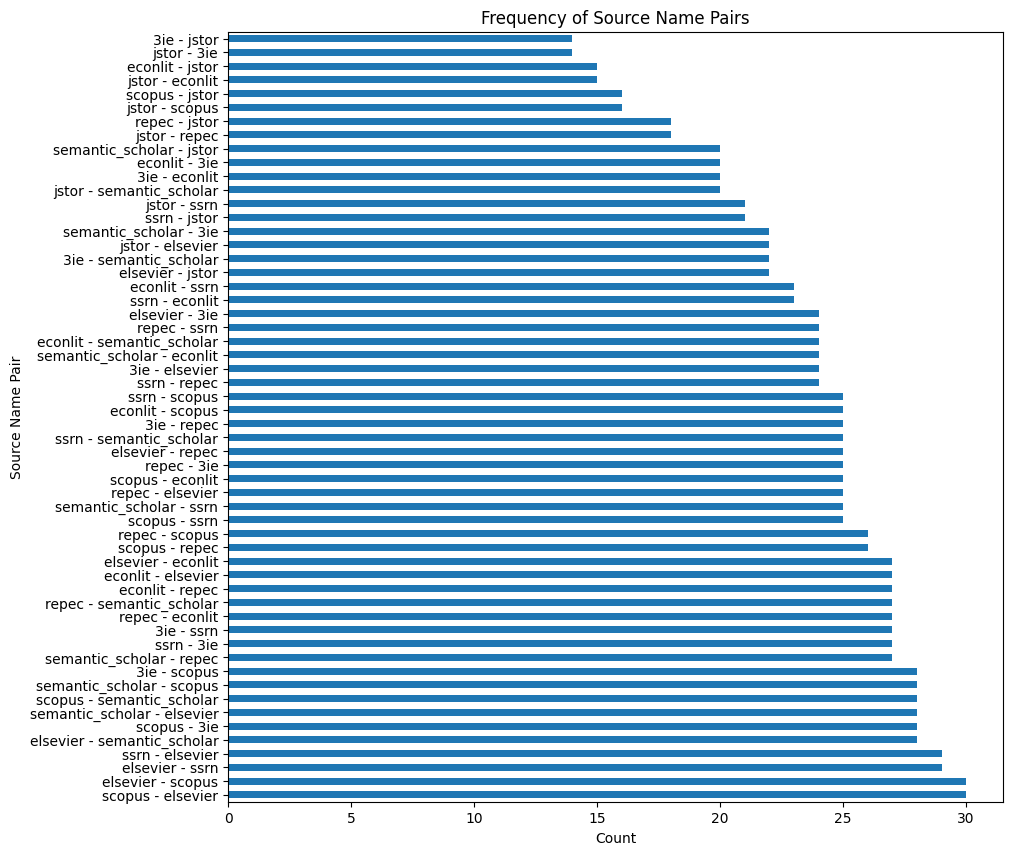

In [120]:
figsize = (10, 10)
fig, ax = plt.subplots(figsize=figsize)
df_cosine_over10Perc['sourcename_pair'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Source Name Pair')
plt.title('Frequency of Source Name Pairs')
plt.show()


In [122]:
df_cosine_over10Perc.to_csv(os.path.join(directory, 'similarity_score_2Kpair_over10Percent_final.csv'), index=False)

In [121]:
len(df_cosine_over10Perc)

1330

In [138]:
df_cosine_over10Perc = pd.read_csv('/content/drive/MyDrive/finalMetaFile/similarity_score_2Kpair_over10Percent.csv')

df_cosine_over10Perc = df_cosine_over10Perc.merge(df_make_pair_2k_pair_noWordCount, left_on='Title 1', right_on='title', how='left')
df_cosine_over10Perc = df_cosine_over10Perc.rename(columns={'sourcename_x': 'sourcename_1', 'sourcename_y': 'sourcename_2'})

df_cosine_over10Perc = df_cosine_over10Perc.merge(df_make_pair_2k_pair_noWordCount, left_on='Title 2', right_on='title', how='left')

df_cosine_over10Perc.drop('title_y', axis=1, inplace=True)
df_cosine_over10Perc.rename(columns={'title_x': 'title_1', 'sourcename_x': 'sourcename_1', 'sourcename_y': 'sourcename_2'}, inplace=True)


df_cosine_over10Perc.drop('title_1', axis=1, inplace=True)
df_cosine_over10Perc = df_cosine_over10Perc.drop(df_cosine_over10Perc[df_cosine_over10Perc['sourcename_1'] == df_cosine_over10Perc['sourcename_2']].index)
df_cosine_over10Perc.head()

,Title 1,Title 2,Similarity Score,sourcename_1,sourcename_2
4,do environmental messages work on the poor? ex...,the times they are a-changing: experimenting w...,0.018571,3ie,econlit
5,do environmental messages work on the poor? ex...,what makes voters turn out: the effects of pol...,0.018852,3ie,econlit
6,do environmental messages work on the poor? ex...,a proposed methodology for literature review o...,0.055741,3ie,econlit
7,do environmental messages work on the poor? ex...,maternity leave and female labor force partici...,0.118904,3ie,econlit
8,do environmental messages work on the poor? ex...,non-core liabilities and interest rate pass-th...,0.108752,3ie,econlit


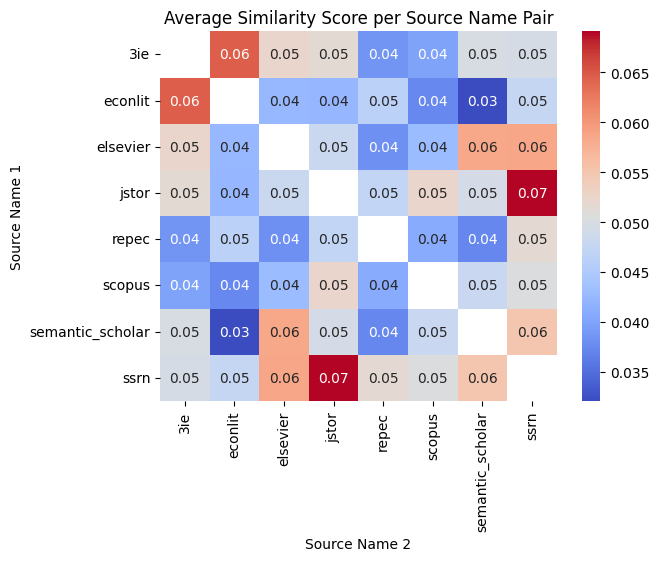

In [139]:
import seaborn as sns

pivot_table = df_cosine_over10Perc.pivot_table(values='Similarity Score', index='sourcename_1', columns='sourcename_2')

sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.xlabel('Source Name 2')
plt.ylabel('Source Name 1')
plt.title('Average Similarity Score per Source Name Pair')
plt.show()

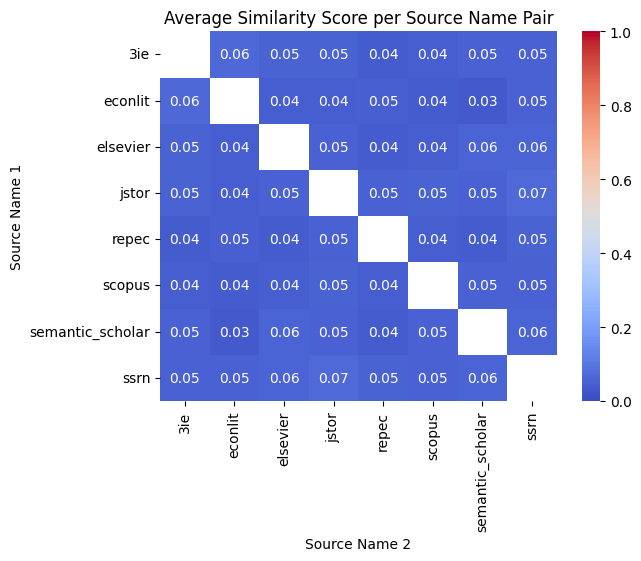

In [140]:
pivot_table = df_cosine_over10Perc.pivot_table(values='Similarity Score', index='sourcename_1', columns='sourcename_2')

sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f", vmin=0, vmax=1)
plt.xlabel('Source Name 2')
plt.ylabel('Source Name 1')
plt.title('Average Similarity Score per Source Name Pair')
plt.show()


# counter vect

In [123]:


from string import printable
from collections import Counter

printable_dict = {c:i for i,c in enumerate(printable)}

def vectorize(title):
    cnt = Counter(title)
    array = [0 for _ in printable]+[0] # Last position is for nonprintable characters
    for c,n in cnt.items():
        if c in printable_dict:
            array[printable_dict[c]]=n
        else:
            array[-1]+=n # Update last position if it's not printable
    return np.array(array)

vects = []
for title in df_make_pair_2k_pair.title:
    vects.append(vectorize(title))

In [125]:
%%time
threshold = 200
min_length = 10


with open('/content/drive/MyDrive/finalMetaFile/counterVect_L1_2kPair.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["Title 1", "Title 2", "Similarity Score"])
# Iterate over title pairs
  for i, v1 in enumerate(vects):
    if sum(v1[:-1]) > min_length: # Only above a minimum number of printable characters
        for j, v2 in enumerate(vects):
            if sum(v2[:-1]) > min_length:
                if i!=j:
                    l1 = np.linalg.norm((v1[:-1] - v2[:-1]), ord=1)
                    if l1 < threshold:
                        t1 = df_make_pair_2k_pair.iloc[i].title
                        t2 = df_make_pair_2k_pair.iloc[j].title
                        writer.writerow([t1, t2, l1])
                        print(f"{t1} _&_ {t2} (L1: {l1:.0f})")


do environmental messages work on the poor? experimental evidence from brazilian favelas _&_ testing the effectiveness of transfer interventions using solomon four-group designs (L1: 48)
do environmental messages work on the poor? experimental evidence from brazilian favelas _&_ a randomized trial of multivitamin supplementation in children with tuberculosis in tanzania (L1: 44)
do environmental messages work on the poor? experimental evidence from brazilian favelas _&_ three essays on climate change adaptation in rural african communities (L1: 42)
do environmental messages work on the poor? experimental evidence from brazilian favelas _&_ effect of scientific argumentation on the development of critical thinking (L1: 50)
do environmental messages work on the poor? experimental evidence from brazilian favelas _&_ environmental non-governmental organizations and urban environmental governance: evidence from china (L1: 40)
do environmental messages work on the poor? experimental evidence

In [126]:
df_countVect_l1 = pd.read_csv('/content/drive/MyDrive/finalMetaFile/counterVect_L1_2kPair.csv')

df_countVect_l1 = df_countVect_l1.merge(df_make_pair_2k_pair_noWordCount, left_on='Title 1', right_on='title', how='left')
df_countVect_l1 = df_countVect_l1.rename(columns={'sourcename_x': 'sourcename_1', 'sourcename_y': 'sourcename_2'})

df_countVect_l1 = df_countVect_l1.merge(df_make_pair_2k_pair_noWordCount, left_on='Title 2', right_on='title', how='left')

df_countVect_l1.drop('title_y', axis=1, inplace=True)
df_countVect_l1.rename(columns={'title_x': 'title_1', 'sourcename_x': 'sourcename_1', 'sourcename_y': 'sourcename_2'}, inplace=True)


df_countVect_l1.drop('title_1', axis=1, inplace=True)
df_countVect_l1 = df_countVect_l1.drop(df_countVect_l1[df_countVect_l1['sourcename_1'] == df_countVect_l1['sourcename_2']].index)
df_countVect_l1.head()

df_countVect_l1['sourcename_pair'] = df_countVect_l1['sourcename_1'] + ' - ' + df_countVect_l1['sourcename_2']
df_countVect_l1.drop(['sourcename_1', 'sourcename_2'], axis=1, inplace=True)


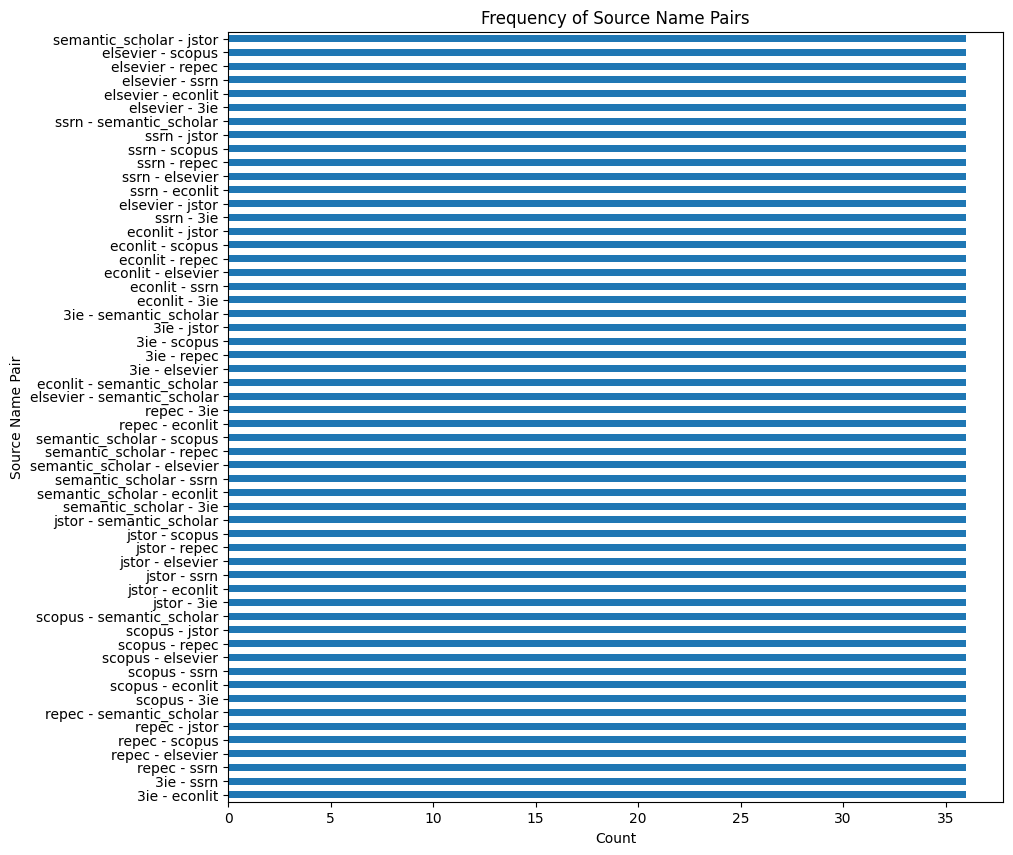

In [128]:
figsize = (10, 10)
fig, ax = plt.subplots(figsize=figsize)
df_countVect_l1['sourcename_pair'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Source Name Pair')
plt.title('Frequency of Source Name Pairs')
plt.show()


In [129]:
len(df_countVect_l1)


2016

In [130]:
df_countVect_l1.to_csv(os.path.join(directory, 'counterVect_L1_2kPair.csv'), index=False)

In [131]:
df_countVect_l1.head()

,Title 1,Title 2,Similarity Score,sourcename_pair
5,do environmental messages work on the poor? ex...,the times they are a-changing: experimenting w...,45.0,3ie - econlit
6,do environmental messages work on the poor? ex...,what makes voters turn out: the effects of pol...,48.0,3ie - econlit
7,do environmental messages work on the poor? ex...,a proposed methodology for literature review o...,24.0,3ie - econlit
8,do environmental messages work on the poor? ex...,socioeconomic status and inequalities in child...,47.0,3ie - econlit
9,do environmental messages work on the poor? ex...,maternity leave and female labor force partici...,33.0,3ie - econlit


# count vect heatmap

In [133]:
df_countVect_l1 = pd.read_csv('/content/drive/MyDrive/finalMetaFile/counterVect_L1_2kPair.csv')

df_countVect_l1 = df_countVect_l1.merge(df_make_pair_2k_pair_noWordCount, left_on='Title 1', right_on='title', how='left')
df_countVect_l1 = df_countVect_l1.rename(columns={'sourcename_x': 'sourcename_1', 'sourcename_y': 'sourcename_2'})

df_countVect_l1 = df_countVect_l1.merge(df_make_pair_2k_pair_noWordCount, left_on='Title 2', right_on='title', how='left')

df_countVect_l1.drop('title_y', axis=1, inplace=True)
df_countVect_l1.rename(columns={'title_x': 'title_1', 'sourcename_x': 'sourcename_1', 'sourcename_y': 'sourcename_2'}, inplace=True)


df_countVect_l1.drop('title_1', axis=1, inplace=True)
df_countVect_l1 = df_countVect_l1.drop(df_countVect_l1[df_countVect_l1['sourcename_1'] == df_countVect_l1['sourcename_2']].index)
df_countVect_l1.head()

,Title 1,Title 2,Similarity Score,sourcename_pair,sourcename_1,sourcename_2
0,do environmental messages work on the poor? ex...,the times they are a-changing: experimenting w...,45.0,3ie - econlit,3ie,econlit
1,do environmental messages work on the poor? ex...,what makes voters turn out: the effects of pol...,48.0,3ie - econlit,3ie,econlit
2,do environmental messages work on the poor? ex...,a proposed methodology for literature review o...,24.0,3ie - econlit,3ie,econlit
3,do environmental messages work on the poor? ex...,socioeconomic status and inequalities in child...,47.0,3ie - econlit,3ie,econlit
4,do environmental messages work on the poor? ex...,maternity leave and female labor force partici...,33.0,3ie - econlit,3ie,econlit


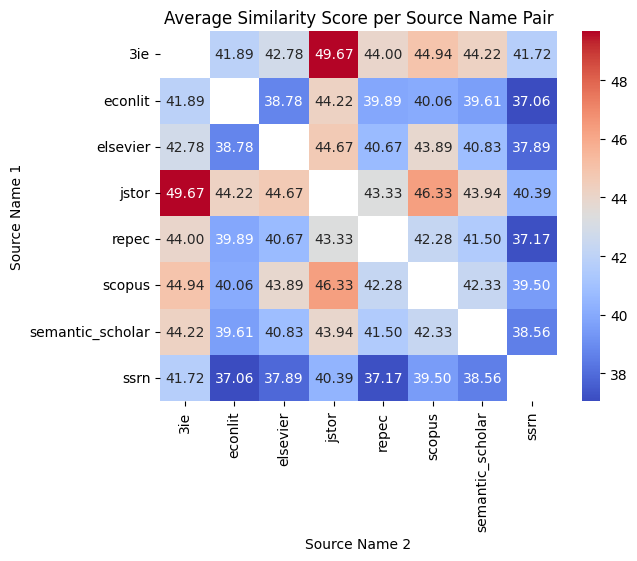

In [134]:
import seaborn as sns

pivot_table = df_countVect_l1.pivot_table(values='Similarity Score', index='sourcename_1', columns='sourcename_2')

sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.xlabel('Source Name 2')
plt.ylabel('Source Name 1')
plt.title('Average Similarity Score per Source Name Pair')
plt.show()


In [143]:
# any duplicates?
threshold = 30
min_length = 10


with open('/content/drive/MyDrive/finalMetaFile/counterVect_L1_2kPair_dupes.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["Title 1", "Title 2", "Similarity Score"])
# Iterate over title pairs
  for i, v1 in enumerate(vects):
    if sum(v1[:-1]) > min_length: # Only above a minimum number of printable characters
        for j, v2 in enumerate(vects):
            if sum(v2[:-1]) > min_length:
                if i!=j:
                    l1 = np.linalg.norm((v1[:-1] - v2[:-1]), ord=1)
                    if l1 < threshold:
                        t1 = df_make_pair_2k_pair.iloc[i].title
                        t2 = df_make_pair_2k_pair.iloc[j].title
                        writer.writerow([t1, t2, l1])
                        print(f"{t1} _&_ {t2} (L1: {l1:.0f})")

do environmental messages work on the poor? experimental evidence from brazilian favelas _&_ a proposed methodology for literature review on operational risk management in banks (L1: 24)
do environmental messages work on the poor? experimental evidence from brazilian favelas _&_ vernacular models of development: an analysis of indonesia under the "new order" (L1: 28)
three essays on climate change adaptation in rural african communities _&_ minimum wage effects on labor market outcomes under search with bargaining (L1: 26)
three essays on climate change adaptation in rural african communities _&_ nonparametric estimation of first price auctions via density quantile function (L1: 26)
three essays on climate change adaptation in rural african communities _&_ optimal policy in an economy with human capital where money is essential (L1: 28)
three essays on climate change adaptation in rural african communities _&_ the advance in partial distribution£ºa new mathematical tool for economic ma